# Wine & Spotify Data w/ Principal Components Analysis & GridSearchCV

In [52]:
#Imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.datasets import load_digits

plt.style.use('fivethirtyeight')

In [22]:
#Load in the wine data
wine = pd.read_csv("../data/winequality_merged.csv")
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [23]:
wine.shape

(6497, 13)

In [24]:
wine.red_wine.value_counts(normalize=True)
# ~25% of the responses are red wine.

0    0.753886
1    0.246114
Name: red_wine, dtype: float64

Which attributes here can we use to identify which class of wine it belongs to?

In [25]:
#Assign red_wine column to variable rw 
rw = wine.red_wine

#Drop red_wine from wine

wine.drop("red_wine", axis = 1, inplace= True)

First let's determine the correlations between the independent variables

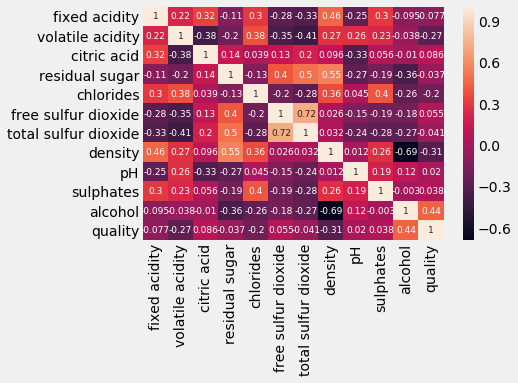

In [26]:
#Correlation heatmap

sb.heatmap(wine.corr(), annot=True, annot_kws={"size": 9})

Multiculineartiy exists when columns highly correlated with one another. One benefit of PCA is that it can deal with multicollinearity pretty well because multicollinearity simply means that you have excess dimensions in your data.

In [27]:
#We need to standardize or scale the data before we can transform our data because the measurements vary 
# among the variables.

#Intialize scaler, you can use minmaxscaler as well.. both the same.
scale = StandardScaler()

#Fit and transform wine data using standard scaler
wine_s = scale.fit_transform(wine)

#let's take a look at the first row of data by the first slice:
wine_s[0]

array([ 0.14247327,  2.18883292, -2.19283252, -0.7447781 ,  0.56995782,
       -1.10013986, -1.44635852,  1.03499282,  1.81308951,  0.19309677,
       -0.91546416, -0.93722961])

In [28]:
#Intialize PCA object
#We're deliberating leaving the n_components parameters alone
pca = PCA()

#Fit and transform wine_s use pca
wine_pca = pca.fit_transform(wine_s)

#Number of components
pca.n_components_

12

In [29]:
pca.n_features_

12

In [30]:
pca.explained_variance_

array([ 3.04201535,  2.65026192,  1.64175951,  1.06878976,  0.84062985,
        0.66050084,  0.56391324,  0.51606227,  0.45844285,  0.29905893,
        0.22762255,  0.03279021])

We need to reduce the number of dimensions from 12, but how do we select how many to keep? Let's visualize how much
variance is explained for each principal component. They will be ranked by the greatest explained variance first. A cumulative variance of 85% can be a great rule of thumb for our threshold in selecting number of components. 


In [31]:
#Shows the percentage of the variance explained by each component
pca.explained_variance_ratio_

array([ 0.25346226,  0.22082117,  0.13679223,  0.0890521 ,  0.07004171,
        0.05503326,  0.04698554,  0.04299857,  0.03819769,  0.02491774,
        0.01896563,  0.0027321 ])

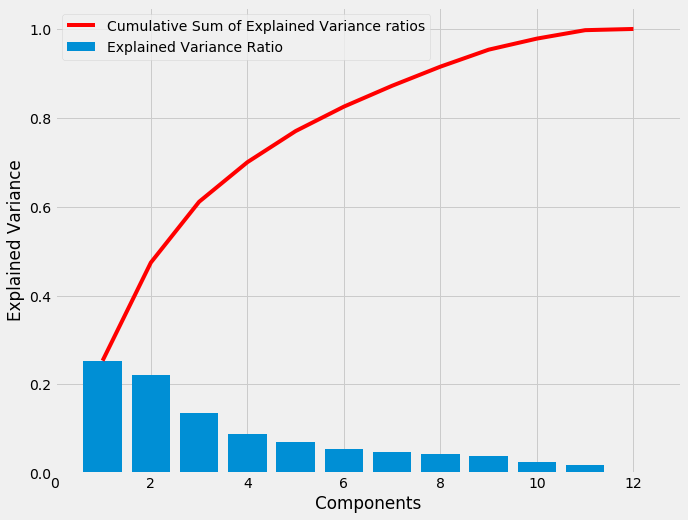

In [32]:
plt.figure(figsize=(10, 8))

components = range(1, pca.n_components_ +1)

plt.bar(components, pca.explained_variance_ratio_, label = "Explained Variance Ratio")
plt.plot(components, np.cumsum(pca.explained_variance_ratio_), 
         c = "r", label = "Cumulative Sum of Explained Variance ratios")

plt.xlabel("Components")
plt.ylabel("Explained Variance")
plt.legend();

At the 85% explained variance level, we are at about 7 coponents. At just 2 components, you can get about 50% of the explained variance (essense of the original dataset). This tell us that if we view this 12-dimension data on a 2D scatter plot then we would be seeing about half of the total variance in the dataset.

In [33]:
pca.components_[1].mean()

0.092576717827446087

In [34]:
pca.explained_variance_.sum()

12.001847290640395

In [35]:
pca.explained_variance_ratio_[:3].sum()

0.61107566218386822

How do you label the components based on the weights?

Let's print out the component weights with their corresponding variables for PC1, PC2, and PC3

In [36]:
#PC1
for col, comp in zip(wine.columns, pca.components_[0]):
    print col, comp

    #Total sulfur dioxide has the strongest weight

fixed acidity -0.256928733111
volatile acidity -0.39493117944
citric acid 0.146460610663
residual sugar 0.318905191475
chlorides -0.313449939668
free sulfur dioxide 0.422691371567
total sulfur dioxide 0.474419684357
density -0.0924375324327
pH -0.20806956646
sulphates -0.29985191609
alcohol -0.0589240827477
quality 0.0874757097877


In [37]:
#PC2
for col, comp in zip(wine.columns, pca.components_[1]):
    print col, comp
    
    #density 

fixed acidity 0.261843062046
volatile acidity 0.105198251341
citric acid 0.144093484947
residual sugar 0.342584967641
chlorides 0.269770095513
free sulfur dioxide 0.111178780564
total sulfur dioxide 0.143947528574
density 0.554920473971
pH -0.152921853598
sulphates 0.1196342033
alcohol -0.49272747405
quality -0.29660090632


In [38]:
#Component 3
for col, comp in zip(wine.columns, pca.components_[2]):
    print col, comp

fixed acidity 0.467486190591
volatile acidity -0.279689315676
citric acid 0.588075565852
residual sugar -0.0755017007908
chlorides 0.0467692077858
free sulfur dioxide -0.0989980148665
total sulfur dioxide -0.101281425438
density -0.0515633823809
pH -0.406787409328
sulphates 0.168691280174
alcohol 0.212931416399
quality 0.295837730114


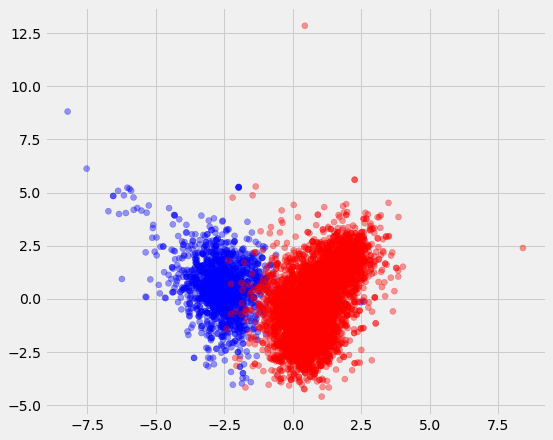

In [39]:
# Create color values from rw for this biplot.
colors = rw.map({0:"r", 1:"b"})

plt.figure(figsize=(8,7))
plt.scatter(wine_pca[:, 0], wine_pca[:, 1], c=colors, alpha=.4);

48% of the cumulative variance of this dataset is plotted. We can make a pretty decent model by putting a line down the middle here since the distinction is quite clear at this point.

Here's the same graph, but plotted with 3 dimensions: 

https://plot.ly/~DarrenK.Lee/1/

# Logistic Regression Model Selection

In [48]:
X = wine_pca[:,:2]
y = rw
# We previously saved the variable rw as the target column, now we will try to build a model to predict if 
# the wine is a red bottle or not. 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)

In [49]:
y.value_counts(normalize= True)

# remember that our null accuracy score to beat is 75%. We can assume that the entire dataset is not red wine,
# and we would be about 75% accurate about that statement. Let's beat this baseline number!

0    0.753886
1    0.246114
Name: red_wine, dtype: float64

In [50]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

lr.score(X_train, y_train)

0.98378489326765184

In [51]:
lr.score(X_test, y_test)

0.98215384615384616

In [52]:
preds = lr.predict(X_test)

In [53]:
cm = confusion_matrix(y_test, preds)
c_matrix = pd.DataFrame(cm, columns= ("Predicted Not Red Wine", "Predicted Red Wine"))
c_matrix

,Predicted Not Red Wine,Predicted Red Wine
0,1223,12
1,17,373


The trained model was applied to new/unseen data in the test set. We see a 95.6% accuracy with the test set in classification. Not bad for a model without a specific boost or optimized parameter tuning! Below, you can see the cross validated scores if we were to include all of the components into play. This is a matter of the context of your data. Falsely classifying may be more serious when you're dealing with Credit Card fraud over classifying wine types.

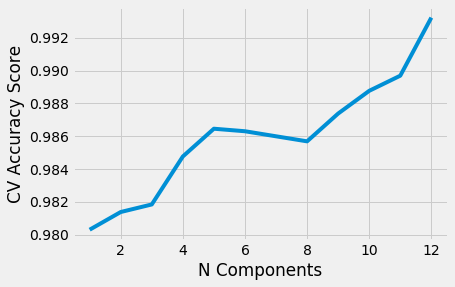

In [59]:
components = range(1, 13)
scores = []

for i in components:
    pca = PCA(n_components=i)
    pca_data = pca.fit_transform(wine_s)
    score = cross_val_score(LogisticRegression(), pca_data, rw, cv = 5, scoring = "accuracy").mean()
    scores.append(score)
    
plt.plot(components, scores)
plt.xlabel("N Components")
plt.ylabel("CV Accuracy Score"); 

# Spotify Song Recommendation 

<b> Attributes </b>


    Acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
    
    Danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

    Instrumentalness: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
    
    Loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
    
    Mode: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

    Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
    
    Tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

    Energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
    

More information here https://developer.spotify.com/web-api/get-audio-features/

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification;

/Users/darrenklee/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Load the datafile "Spotify_Data.pkl" and check it out
df = pd.read_pickle("../data/Spotify_Data.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2017 entries, Mask_Off***Future to I_Wanna_Get_Better***Bleachers
Data columns (total 9 columns):
acousticness        2017 non-null float64
mode                2017 non-null int64
tempo               2017 non-null float64
loudness            2017 non-null float64
danceability        2017 non-null float64
instrumentalness    2017 non-null float64
valence             2017 non-null float64
energy              2017 non-null float64
target              2017 non-null int64
dtypes: float64(7), int64(2)
memory usage: 157.6+ KB


In [3]:
df.head(n = 8)

,acousticness,mode,tempo,loudness,danceability,instrumentalness,valence,energy,target
Mask_Off***Future,0.01020,1,150.062,-8.795,0.833,0.021900,0.286,0.434,1
Redbone***Childish_Gambino,0.19900,1,160.083,-10.401,0.743,0.006110,0.588,0.359,1
Xanny_Family***Future,0.03440,1,75.044,-7.148,0.838,0.000234,0.173,0.412,1
Master_Of_None***Beach_House,0.60400,1,86.468,-15.236,0.494,0.510000,0.230,0.338,1
Parallel_Lines***Junior_Boys,0.18000,0,174.004,-11.648,0.678,0.512000,0.904,0.561,1
Sneakin’***Drake,0.00479,1,85.023,-6.682,0.804,0.000000,0.264,0.560,1
Childs_Play***Drake,0.01450,1,80.030,-11.204,0.739,0.000007,0.308,0.472,1
Gyöngyhajú_lány***Omega,0.02020,0,144.154,-11.609,0.266,0.664000,0.393,0.348,1


In [4]:
df.describe()

,acousticness,mode,tempo,loudness,danceability,instrumentalness,valence,energy,target
count,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,0.187590,0.612295,121.603272,-7.085624,0.618422,0.133286,0.496815,0.681577,0.505702
std,0.259989,0.487347,26.685604,3.761684,0.161029,0.273162,0.247195,0.210273,0.500091
min,0.000003,0.000000,47.859000,-33.097000,0.122000,0.000000,0.034800,0.014800,0.000000
25%,0.009630,0.000000,100.189000,-8.394000,0.514000,0.000000,0.295000,0.563000,0.000000
50%,0.063300,1.000000,121.427000,-6.248000,0.631000,0.000076,0.492000,0.715000,1.000000
75%,0.265000,1.000000,137.849000,-4.746000,0.738000,0.054000,0.691000,0.846000,1.000000
max,0.995000,1.000000,219.331000,-0.307000,0.984000,0.976000,0.992000,0.998000,1.000000


In [5]:
df.groupby("target").mean()

,acousticness,mode,tempo,loudness,danceability,instrumentalness,valence,energy
target,,,,,,,,
0,0.221670,0.647944,120.666027,-6.811743,0.589648,0.091135,0.469836,0.673138
1,0.154279,0.577451,122.519382,-7.353329,0.646547,0.174486,0.523186,0.689826


In [6]:
df.shape

(2017, 9)

In [9]:
scale = StandardScaler()

df_s = scale.fit_transform(df)
df_s[0]

array([-0.68246675,  0.79573763,  1.06670945, -0.45453036,  1.33287384,
       -0.40786448, -0.8530387 , -1.17770008,  0.98866121])

In [10]:
pca = PCA()

#Fit and transform wine_s use pca
df_pca = pca.fit_transform(df_s)

#Number of components
pca.n_components_

9

In [11]:
pca.explained_variance_ratio_

array([ 0.29149458,  0.16141124,  0.1371159 ,  0.10631176,  0.09793145,
        0.08009001,  0.06427768,  0.04243396,  0.01893342])

In [12]:

pca.explained_variance_ratio_[:2].sum()

# let's train a model on the first 3 components

0.45290581932796264

In [13]:
#Component 1
for col, comp in zip(df.columns, pca.components_[0]):
    print col, comp

    #loudness & accousticness stands out

acousticness 0.482286036027
mode 0.0716391235675
tempo -0.126976596691
loudness -0.53018490398
danceability -0.194882609954
instrumentalness 0.243029757058
valence -0.289090366667
energy -0.530833266252
target -0.0514687844621


In [14]:
#Component 2
for col, comp in zip(df.columns, pca.components_[1]):
    print col, comp
    
    #danceability & valance show importance

acousticness -0.0935129833116
mode 0.0414554816678
tempo 0.360431836379
loudness 0.203562819239
danceability -0.648463936048
instrumentalness 0.048671252326
valence -0.501984419425
energy 0.196225097964
target -0.323760438233


In [15]:
#Component 3
for col, comp in zip(df.columns, pca.components_[2]):
    print col, comp
    
    #instrumentalness & the target variable

acousticness -0.17270921566
mode -0.379150689943
tempo 0.30154860193
loudness -0.121406073935
danceability -0.0337932426864
instrumentalness 0.56763472057
valence -0.0899687623104
energy 0.102653642306
target 0.615436413701


In [16]:
from sklearn.ensemble import AdaBoostClassifier

In [17]:
#Create X and y variables
X = df.drop("target", axis = 1)
y = df.target

#Intialize, fit, and score the model
ada = AdaBoostClassifier()
ada.fit(X, y)

score = ada.score(X, y)

print ("The model produces an accuracy score of {:.2f} percent before we scale and transform the data via PCA".format(score*100))

The model produces an accuracy score of 75.16 percent before we scale and transform the data via PCA


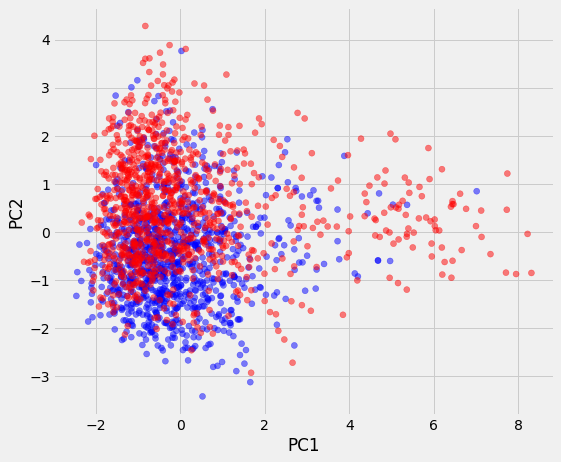

In [68]:
# In this biplot, the reds are songs that this user does not like, and blue are ones they like.
colors = y.map({0:"r", 1:"b"})

plt.figure(figsize=(8,7))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=colors, alpha=.5)
plt.xlabel("PC1")
plt.ylabel("PC2");

# compared to our first example w/ wine data, the line is harder to draw in terms of separation of classes.

In [20]:
# creating a model using the first 2 PCA's:

X = df_pca[:,:2]
y = df.target

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 123)

In [32]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

ada.score(X_train, y_train)

0.69874167283493704

In [33]:
ada.score(X_test, y_test)

0.68618618618618621

Generally, it's a habit to stick with about 85% of the cumulative variance of the original dataset. You'll see at the very end of this notebook how much of a difference that makes. With just 2 PC's, we only capture ~45% of the essence in the original data. Let's see how much the model improves with the same model selection, and just one additional PC.

In [34]:
# let's try to train the model again, but this time with 3 PCA's instead.
X3 = df_pca[:,:3]
y = df.target

In [ ]:
#test = df_pca[:,:3]
#df = pd.DataFrame(test)
#df.to_csv("spotify_3_PCA.csv")

### click on the link below to see this plotted in 3D:

https://plot.ly/~DarrenK.Lee/3/

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size = .33)

In [37]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

print ada.score(X_train, y_train)
print ada.score(X_test, y_test)

0.948926720947
0.927927927928


In [38]:
preds = ada.predict(X_test)

In [39]:
cm = confusion_matrix(y_test, preds)
cm_ada = pd.DataFrame(cm, columns= ("Predicted to not like Song", "Predicted to like Song"))
cm_ada

,Predicted to not like Song,Predicted to like Song
0,310,26
1,22,308


In [40]:
# Row totals
y_test.value_counts()

0    336
1    330
Name: target, dtype: int64

In [66]:
print "\nprecision score:"
print precision_score(y_test, preds)
print "\nrecall score:"
print recall_score(y_test, preds)
print "\naccuracy score:"
print accuracy_score(y_test, preds)

# these accuracy scores beat both our null accuracy, and also our initial AdaBoost model on the pre-transformed dataset
# we can fine tune the model by adding n_estimators to the AdaBoostClassifer parameter to further boost.


precision score:
0.922155688623

recall score:
0.933333333333

accuracy score:
0.927927927928


The confusion matrix outputs 17 False Positives(FP) and 20 False Negatives(FN) above. Is it better to have more FP or FN as a result? The intuition for FN is a prediction to not like a song, although in actuality they like it. If this were a song recomendation engine, we would've never played this song for this user in the first place, and we would simply never know if they would like it or not since there's an initial assumption that they wouldn't enjoy it. False Positives would be the prediction that one might enjoy a particular song, but they actually do not like it at all. 

In general, the business risk in this scenario is not as severe as someone in the position building a model to prevent fraud for credit card users. The Type II Error would be the FN rates where we incorrectly predict the interaction is not fraud. Allowing fruad to happen has a higher cost to all parties involved, and is much worse than FP rates in this binary classification example. 

<b> Model Evaluation Techniques: </b>

True Positives (TP): Number of correct positive predictions

True Negatives (TN): Number of correct negative predictions

False Positives (FP): Number incorrect positive predictions

False Negatives (FN): Number of incorrect negative predictions

Recall aka sensitivity aka the True Positive Rate: The number of correct positive predictions divided by number of positive instances

Precision: The number of correct positive predictions divided by number of positive predictions

False Positive Rate aka Fall Out: The number of incorrect positive predictions divided by number of negative instances

True Negative Rate aka Specificity: The number of correct negative predictions divided by number of negative instances

In [48]:
#Derive probabilities of class 1 from the test set
test_probs = ada.predict_proba(X_test)[:,1]
#Pass in the test_probs variable and the true test labels aka y_test in the roc_curve function
fpr, tpr, thres = roc_curve(y_test, test_probs)
#Outputs the fpr, tpr, for varying thresholds

ROC (receiver operating characteristic) curve is a commonly used way to visualize the performance of a binary classifier. The ROC curve is close to a perfect model, and away from the line of randomness (dotted line). 

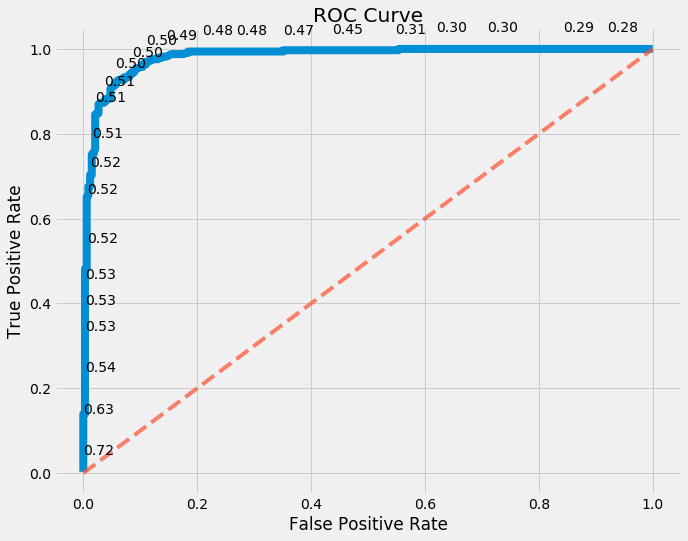

In [49]:
#Plot ROC_curve with the threshold value
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, linewidth=8)
plt.plot([0,1], [0,1], "--", alpha=.7)
for label, x, y in zip(thres[::10], fpr[::10], tpr[::10]):
    plt.annotate("{0:.2f}".format(label), xy=(x, y + .04))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show();

In [54]:
# Rerun X and y variables to the original data
X = df.drop("target", axis = 1)
y = df.target

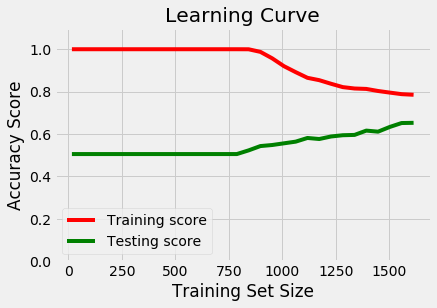

In [55]:
from sklearn.model_selection import learning_curve

#1. Create CV training and test scores for various training set sizes
#Use N_estimators = 150 for AdaBoost model
train_sizes, train_scores, test_scores = learning_curve(AdaBoostClassifier(n_estimators= 150), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring='accuracy', 
                                                        # 30 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 30))

#2.We need to compute average of each 5-fold cv
train_scores = train_scores.mean(axis =1)
test_scores = test_scores.mean(axis = 1)

#3. Create lines
plt.plot(train_sizes, train_scores, color="r",  label="Training score")
plt.plot(train_sizes, test_scores, color="g", label="Testing score")

#4. Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.ylim(0.0, 1.1)
plt.legend(loc="best")
plt.figure(figsize= (10, 8))
plt.show();

Some of you may wonder if this dataset has enough data to begin with. We can see that the training & testing score curves start to converge near the end. There is reason to believe that more rows of data is likely to help very slightly in this case. The lines will begin to converge if so. Adding more
features, however, is different and is very likely to help because it will increase the complexity of this model.

https://www.dataquest.io/blog/learning-curves-machine-learning/

# Grid Search tuning parameter

Grid Search will help us iterate over a range of estimators to optimize the model. We will fit GridSearchCV to the data with 3 PC's to find the optimum parameters.

In [56]:
from sklearn.grid_search import GridSearchCV;

/Users/darrenklee/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [57]:
#Range of estimators to test the in the model
est_range = range(50, 1050, 100)

#Dictionary of parameter values 
param_grid_ada = {}

param_grid_ada["n_estimators"] = est_range

In [58]:
#Intialize Grid
grid_ada = GridSearchCV(AdaBoostClassifier(), 
                       param_grid = param_grid_ada, cv = 5, scoring = "accuracy")

#Fit grid on data
grid_ada.fit(X3, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 150, 250, 350, 450, 550, 650, 750, 850, 950]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [59]:
grid_ada.best_params_

{'n_estimators': 250}

In [60]:
grid_ada.best_score_

0.9003470500743679

In [61]:
# a quick reminder that we have beaten the null accuracy of 50%. Once again, we can blindly guess that a user will
# like all of the given songs, and will be correct 50% of the time!

y.value_counts(normalize= True)

1    0.505702
0    0.494298
Name: target, dtype: float64

In [62]:
# 85% Explained Variance ratio 
pca_85 = PCA(.85).fit(df_pca)

# Number components
pca_85.n_components_

6

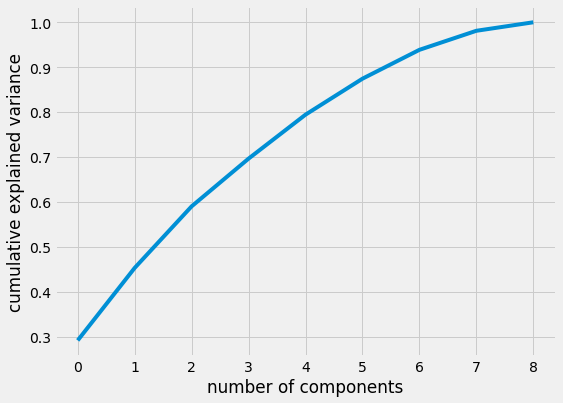

In [63]:
#Intialize and fit spotify data using PCA
pca_cum = PCA().fit(df_pca)
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca_cum.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

As mentioned previously, the threshold to select 85% cumulative explained variance is what we typically want. For computational reasons, 3 Principal Components created a model in which I'm quite pleased to share. Looking at the range of PC's below show us where marginal accuracy diminishes at a certain point. 


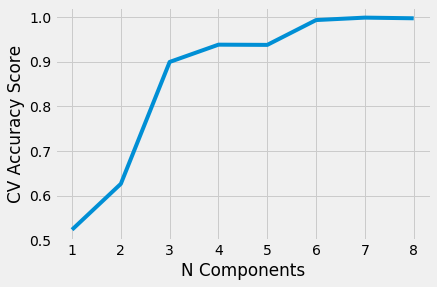

In [64]:
components = range(1, 9)
scores = []

for i in components:
    pca = PCA(n_components=i)
    pca_data = pca.fit_transform(df_s)
    score = cross_val_score(AdaBoostClassifier(), pca_data, y, cv = 5, scoring = "accuracy").mean()
    scores.append(score)
    
plt.plot(components, scores)
plt.xlabel("N Components")
plt.ylabel("CV Accuracy Score");

# Resources:

https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/
